In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Familiar stack packages
import numpy as np
from lsst.daf.butler import Butler
import lsst.geom as geom
from astropy.io import ascii as astascii
import glob
import astropy.table as astTable
import fitsio
import healpy as hp
import numpy.lib.recfunctions as rfn
import smatch
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

import lsst.afw.image as afwImage
from astropy.visualization import ZScaleInterval
from xlens.process_pipe.anacal_detect import (
    AnacalDetectPipe, AnacalDetectPipeConfig
)

In [ ]:
data_all = []
for ifield in ["BGS_BRIGHT_NGC_clustering.dat", "BGS_BRIGHT_SGC_clustering.dat"]:
    fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/%s.fits" % ifield
    data = fitsio.read(fname)
    ra = data['RA']
    dec = data['DEC']
    theta = np.deg2rad(90.0 - dec)
    phi = np.deg2rad(ra)
    pix = hp.ang2pix(NSIDE, theta, phi, nest=True)
    mm = mask[pix]
    data_all.append(data[mm])
data_all = rfn.stack_arrays(data_all, usemask=False)

In [28]:
NSIDE = 1024
mask = hp.read_map("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/fdfc_hp_window.fits", nest=True, dtype=bool)
ifield = "spec-galaxy-zlt03"
fname = f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/%s.fits" % ifield
data = fitsio.read(fname)
ra = data['ra']
dec = data['dec']
theta = np.deg2rad(90.0 - dec)
phi = np.deg2rad(ra)
pix = hp.ang2pix(NSIDE, theta, phi, nest=True)
mm = mask[pix]
data = data[mm]

In [152]:
zlim = 0.3
data1 = data_all[data_all["Z"] < zlim]
data2 = data[data["redshift"] < zlim]
ra1 = data1["RA"]
dec1 = data1["DEC"]
z1 = data1["Z"]
ra2 = data2["ra"]
dec2 = data2["dec"]
z2 = data2["redshift"]

radius_deg = 1.5 / 3600.0 

# smatch returns pairs of indices and distances (in degrees)
# Use maxmatch>1 to get all candidates, then we'll de-duplicate by best distance.
matches = smatch.match(
    ra1=ra1, dec1=dec1,radius1=radius_deg, 
    ra2=ra2, dec2=dec2,
    maxmatch=1,
)
mask1 = np.ones(len(z1), dtype=bool)
mask1[matches["i1"]] = False
z = np.hstack([z1[mask1], z2])
ra = np.hstack([ra1[mask1], ra2])
dec = np.hstack([dec1[mask1], dec2])

In [38]:
if False:
    mat = np.column_stack([ra, dec, z])  # shape (N, 3)
    arr = rfn.unstructured_to_structured(
        mat,
        dtype=[('ra','f8'), ('dec','f8'), ('z','f4')]
    )
    fitsio.write("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/low_redshift_gals/gals.fits", arr)
    plt.scatter(ra, dec, s=0.1)

In [45]:
ls /gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_mask/10045/

1/   14/  19/  23/  28/  32/  37/  41/  46/  50/  55/  6/   64/  69/  74/  8/
10/  15/  2/   24/  29/  33/  38/  42/  47/  51/  56/  60/  65/  7/   75/  80/
11/  16/  20/  25/  3/   34/  39/  43/  48/  52/  57/  61/  66/  70/  77/  9/
12/  17/  21/  26/  30/  35/  4/   44/  49/  53/  58/  62/  67/  71/  78/
13/  18/  22/  27/  31/  36/  40/  45/  5/   54/  59/  63/  68/  73/  79/


In [14]:
ii = 5
tract_id = 10045
tp_list =fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/tracts_fdfc_v1_final.fits")
patch_db = tp_list[tp_list["tract"] == tract_id]["patch"]
patch_x = patch_db // 100
patch_y = patch_db % 100
patch_ids = patch_x + patch_y * 9
patch_ids = np.sort(patch_ids)
patch_id = patch_ids[ii]

aa = fitsio.read(f"/gpfs02/work/xiangchong.li/work/hsc_data/s23b/low_redshift_gals/{tract_id}/{patch_id}/gals.fits")
x = aa["x"]
y = aa["y"]

# Set up the configuration
config = RingsSkyMapConfig()
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0 / 60  # degrees
config.pixelScale = 0.168  # arcsec/pixel
skymap = RingsSkyMap(config)

config = AnacalDetectPipeConfig()
config.anacal.force_size = False
config.anacal.num_epochs = 8
config.anacal.do_noise_bias_correction = True
task = AnacalDetectPipe(config=config)

def read_files(tract_id, patch_id):
    calexp_dir = f"{os.environ['s23b_calexp']}/{tract_id}/{patch_id}/i"
    exp_fname = glob.glob(os.path.join(calexp_dir, "*.fits"))[0]
    exposure = afwImage.ExposureF.readFits(exp_fname)
    mask_dir = f"{os.environ['s23b_mask']}/{tract_id}/{patch_id}"
    mask_fname = os.path.join(mask_dir, "mask2.fits")
    bmask = fitsio.read(mask_fname)
    nim_dir = f"{os.environ['s23b_nimg']}/{tract_id}/{patch_id}/i"
    nim_fname = glob.glob(os.path.join(nim_dir, "*.fits"))[0]
    bmask = (bmask | (fitsio.read(nim_fname) <=2).astype(np.int16))
    corr_fname = f"{os.environ['s23b_noisecorr']}/{tract_id}.fits"
    noise_corr = fitsio.read(corr_fname)
    return {
        "exposure": exposure,
        "mask": bmask,
        "noise_corr": noise_corr,
    }


patch_info = skymap[tract_id][patch_id]
wcs = patch_info.getWcs()
bbox = patch_info.getOuterBBox()

res = read_files(tract_id, patch_id)
seed = (tract_id * 1000 + patch_id) * 5
out = task.anacal.prepare_data(
    exposure=res["exposure"],
    seed=seed,
    noise_corr=res["noise_corr"],
    detection=None,
    band=None,
    skyMap=skymap,
    tract=tract_id,
    patch=patch_id,
    mask_array=res["mask"],
)
catalog = task.anacal.run(**out)

In [15]:
if False:
    x, y = wcs.skyToPixelArray(
        ra=ra, 
        dec=dec,
        degrees=True,
    )
    bb = res["exposure"].getBBox()
    mm = (x > bb.getBeginX()) & (y> bb.getBeginY()) & (x < bb.getEndX()) & (y< bb.getEndY())
    x = x[mm] - bb.getBeginX()
    y = y[mm] - bb.getBeginY()
    z = z[mm]

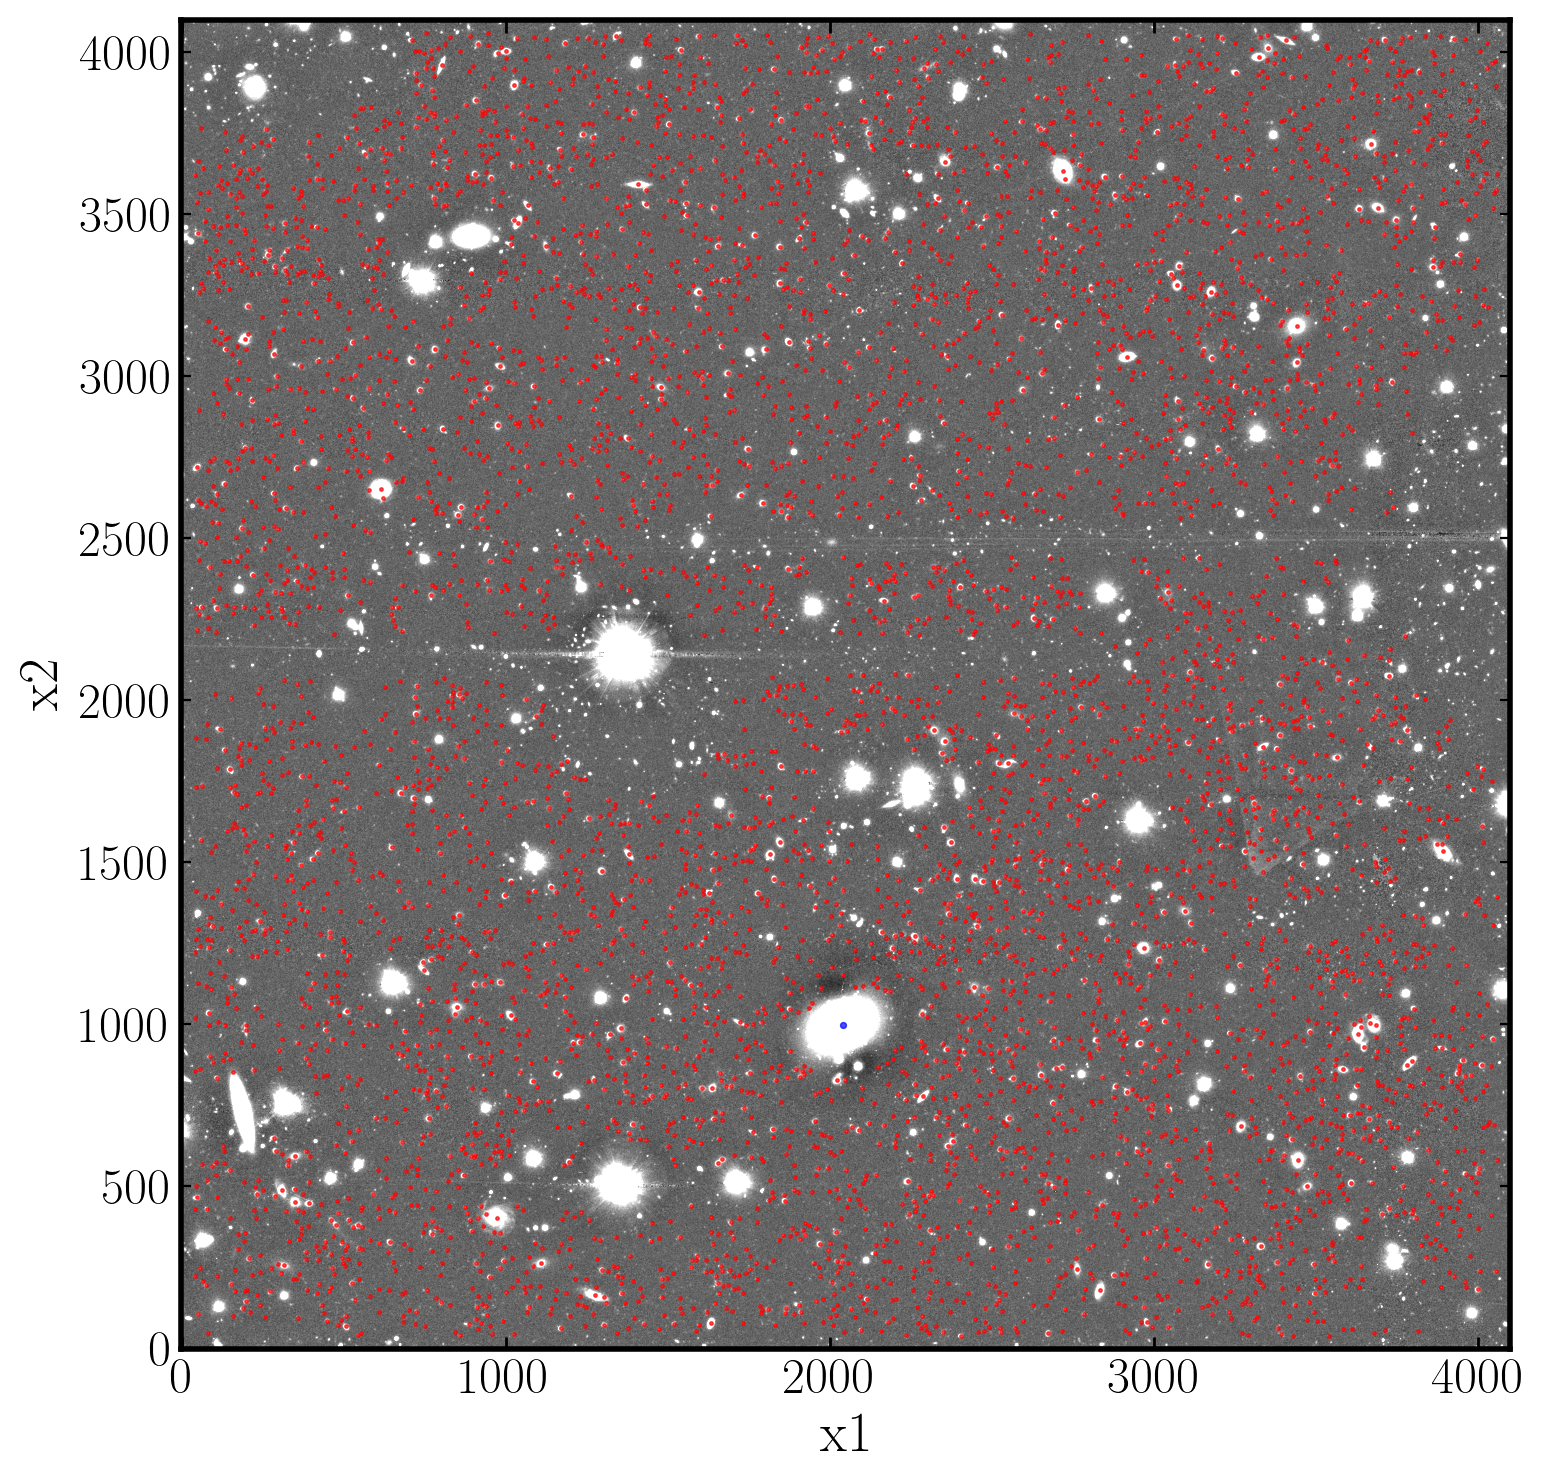

In [16]:
plt.close()
image = out["gal_array"]
bb = res["exposure"].getBBox()
x1 = catalog["x1"] / 0.168 - bb.beginX
x2 = catalog["x2"] / 0.168 - bb.beginY

# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(res["exposure"].image.array, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
#ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.scatter(x1, x2, s=1.5, c='red', edgecolors='red', linewidths=0.5, alpha=0.7)
ax.scatter(x, y, s=4.5, c='blue', edgecolors='blue', linewidths=0.5, alpha=0.7)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

In [17]:
if False:
    bd = res["exposure"].mask.getMaskPlaneDict()
    ibb = 17
    bn = list(bd.keys())[ibb]
    print(bn)
    
    image = ((res["exposure"].mask.array & 2**bd[bn]) > 0).astype(int)
    
    interval = ZScaleInterval()
    vmin, vmax = interval.get_limits(image)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, origin='lower', cmap='gray')
    
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    
    plt.tight_layout()
    plt.show()

In [19]:
def radial_profile(exposure, y0, x0, rmax=600, bin_size=30):
    img_arr = exposure.image.array
    mask_arr = exposure.mask.array
    var_arr = exposure.variance.array

    H, W = img_arr.shape

    # clamp the crop to image bounds
    y_min = max(0, int(y0 - rmax))
    y_max = min(H, int(y0 + rmax + 1))
    x_min = max(0, int(x0 - rmax))
    x_max = min(W, int(x0 + rmax + 1))

    # crop
    image = img_arr[y_min:y_max, x_min:x_max]
    mm    = mask_arr[y_min:y_max, x_min:x_max]
    vim   = var_arr[y_min:y_max, x_min:x_max]

    var = np.nanmean(vim[mm == 0])
    plt.close() 
    #plt.imshow(image , origin='lower', cmap='gray', vmin=vmin, vmax=vmax) 
    fig, ax = plt.subplots()
    ax.imshow(image, cmap="gray", origin="lower", vmin=vmin, vmax=vmax)
    
    # Compute stamp center
    y_center = image.shape[0] / 2
    x_center = image.shape[1] / 2
    
    # Add a circle centered on the stamp
    radius = 315  # change this to whatever radius you want (in pixels)
    circle = plt.Circle(
        (x_center, y_center),
        radius,
        edgecolor="red",
        facecolor="none",  # ensures it's not filled
        linewidth=2
    )
    ax.add_patch(circle)

    # build coordinate grid relative to the point
    y, x = np.indices(image.shape)
    y_center = y0 - y_min
    x_center = x0 - x_min
    r = np.sqrt((x - x_center)**2 + (y - y_center)**2)

    # radial bins and mask
    rbin = (r / bin_size).astype(int)
    valid = (r <= rmax) & (mm == 0)

    # bin means normalized by noise
    sum_pix = np.bincount(rbin[valid], weights=image[valid])
    npixs   = np.bincount(rbin[valid]) + 0.01
    mean = sum_pix / npixs / np.sqrt(var / npixs)

    radii = (np.arange(len(mean)) + 0.5) * bin_size
    return radii, mean

In [20]:
x

array([2042.3527], dtype='>f4')

In [21]:
y

array([999.0727], dtype='>f4')

2042.3527 999.0727


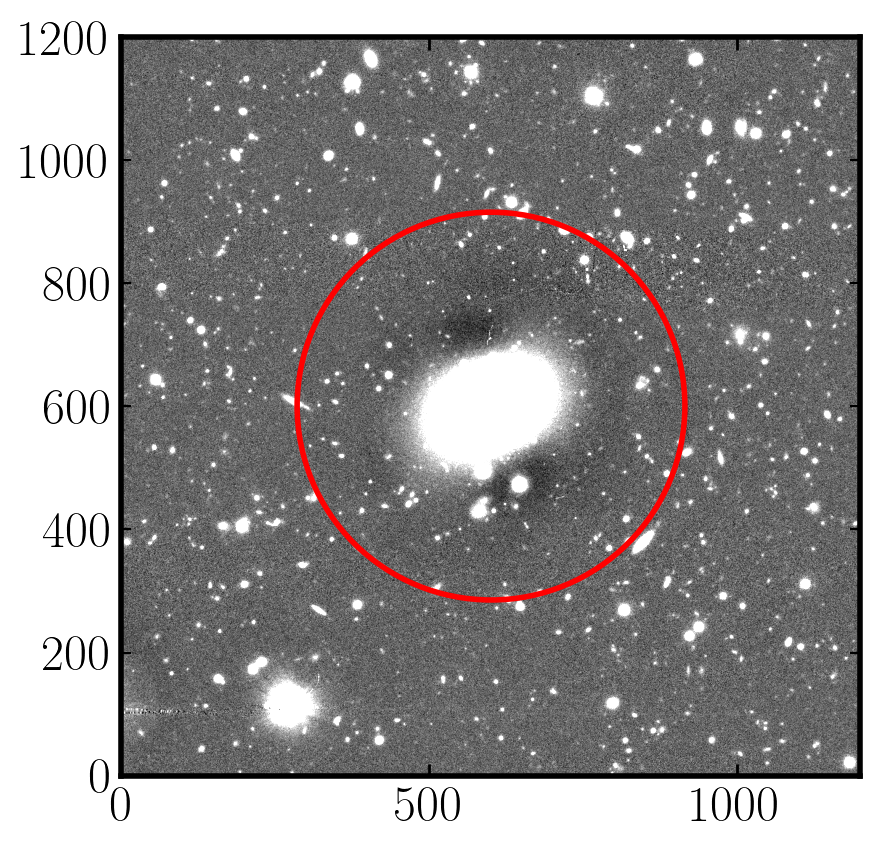

In [22]:
ic = 0
print(x[ic], y[ic])
rr, pp = radial_profile(res["exposure"], y[ic], x[ic])

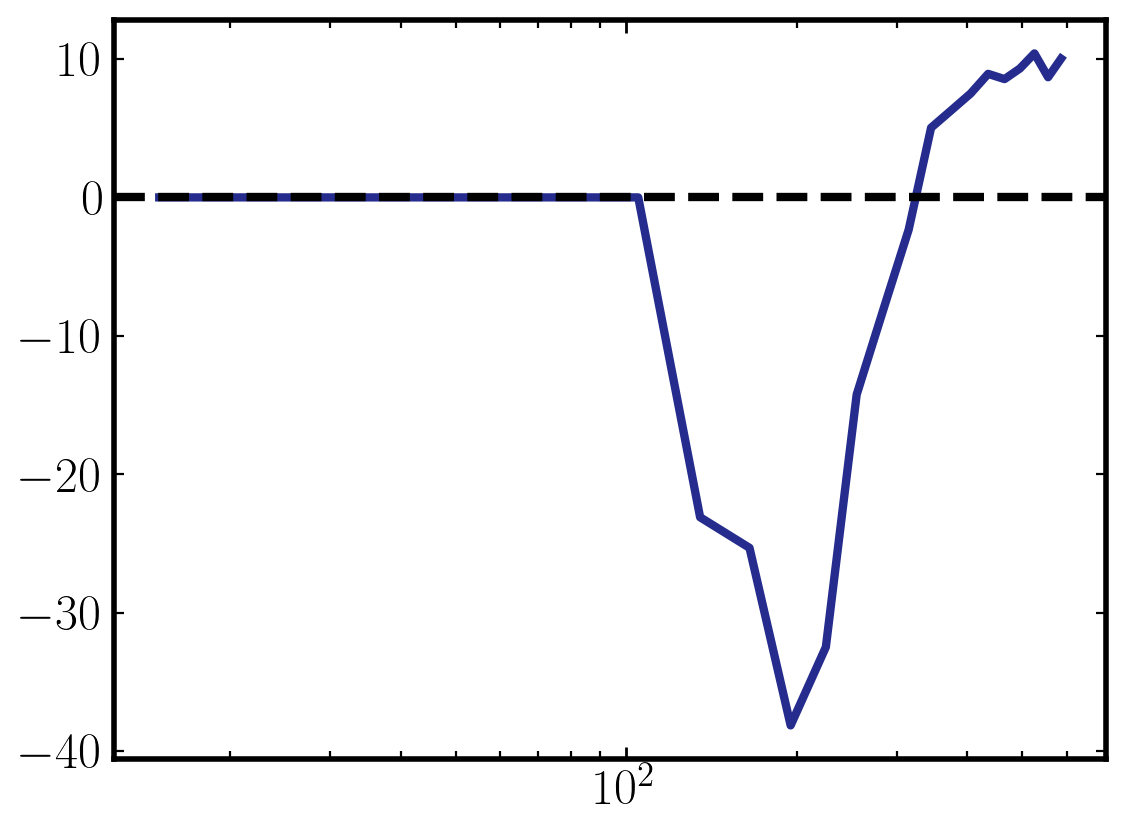

In [23]:
plt.plot(rr, pp)
plt.xscale("log")
plt.axhline(y=0.0, ls="--", color="black")

In [219]:
rr[np.argmin(pp)]

315.0

In [220]:
np.min(pp)

-7.001621020853965

In [88]:
y

array([1791.68044534])

In [89]:
x

array([2427.80781926])

In [1]:
315 * 0.168

52.92